In [1]:
!pip install PyWavelets
!pip install xgboost
!pip install tensorflow
!pip install scikit-learn

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from keras.callbacks import EarlyStopping
import pywt
from scipy.fft import fft
from keras.models import Sequential

In [3]:
file_path= '/content/combined_battery_data.csv'
data=pd.read_csv(file_path, delimiter=',')

In [4]:
data=data.dropna()
missing_values=data.isnull().sum()
print(missing_values[missing_values>0])

Series([], dtype: int64)


In [5]:
duplicates=data.duplicated()
print(data[duplicates])

Empty DataFrame
Columns: [Battery_id, Cycle Number, Voltage, Ambient temp, Current, Temperature, Current Load, Voltage Load, Time, Fluctuation Index, Skewness Index, Kurtosis Index, Capacity, SoC, Discharge Rate, Energy, Battery Voltage Slope, Voltage Range, Battery Impedance, Power, Temperature Deviation]
Index: []

[0 rows x 21 columns]


In [6]:
data['RUL'] = data.groupby('Battery_id')['Cycle Number'].transform(lambda x: x.max() - x)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770070 entries, 0 to 770069
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Battery_id             770070 non-null  int64  
 1   Cycle Number           770070 non-null  int64  
 2   Voltage                770070 non-null  float64
 3   Ambient temp           770070 non-null  int64  
 4   Current                770070 non-null  float64
 5   Temperature            770070 non-null  float64
 6   Current Load           770070 non-null  float64
 7   Voltage Load           770070 non-null  float64
 8   Time                   770070 non-null  float64
 9   Fluctuation Index      770070 non-null  float64
 10  Skewness Index         770070 non-null  float64
 11  Kurtosis Index         770070 non-null  float64
 12  Capacity               770070 non-null  float64
 13  SoC                    770070 non-null  float64
 14  Discharge Rate         770070 non-nu

In [8]:
data.describe()

,Battery_id,Cycle Number,Voltage,Ambient temp,Current,Temperature,Current Load,Voltage Load,Time,Fluctuation Index,...,Capacity,SoC,Discharge Rate,Energy,Battery Voltage Slope,Voltage Range,Battery Impedance,Power,Temperature Deviation,RUL
count,770070.000000,770070.000000,770070.000000,770070.000000,770070.000000,770070.000000,770070.000000,770070.000000,770070.000000,770070.000000,...,770070.000000,770070.000000,770070.000000,770070.000000,770070.000000,770070.000000,770070.000000,770070.000000,7.700700e+05,770070.000000
mean,32.748683,56.180995,3.417351,19.327648,-1.578464,27.281331,1.487260,2.015373,1883.618060,0.274227,...,1.478739,73.936971,-0.789232,-1.478739,-0.000137,1.848357,-332.271430,-5.283510,3.346629e-17,58.434653
std,15.910368,46.851345,0.419136,12.332820,1.161964,14.062328,1.268142,1.134413,1390.592695,0.074246,...,0.351855,17.592731,0.580982,0.351855,0.000297,0.339587,5537.971446,2.205411,4.152157e+00,48.928744
min,5.000000,1.000000,0.192738,4.000000,-4.038796,2.904756,-2.000000,0.000000,0.000000,0.000103,...,-0.002425,-0.121238,-2.019398,-3.024383,-0.022194,0.001614,-169024.758010,-13.472789,-2.163345e+01,0.000000
25%,25.000000,19.000000,3.282026,4.000000,-2.010765,11.462661,0.998000,1.304000,795.047000,0.221793,...,1.311085,65.554238,-1.005382,-1.737177,-0.000233,1.559900,-494.714029,-6.527487,-2.107441e+00,18.000000
50%,36.000000,41.000000,3.473762,24.000000,-1.989172,30.083127,1.998000,2.431000,1639.781000,0.267677,...,1.533216,76.660788,-0.994586,-1.533216,-0.000189,1.787652,-78.242966,-5.583059,-7.086315e-02,44.000000
75%,45.000000,88.000000,3.664314,24.000000,-0.995509,36.023366,1.999000,2.776000,2620.781000,0.329369,...,1.737177,86.858857,-0.497754,-1.311085,-0.000078,2.092426,-9.160808,-3.480186,2.090297e+00,91.000000
max,56.000000,197.000000,4.542427,44.000000,0.030461,69.869746,4.148800,97.000000,6574.671000,0.996250,...,3.024383,151.219132,0.015231,0.002425,0.001355,4.186368,53295.490673,0.000584,2.138382e+01,196.000000


In [9]:
data.head()

,Battery_id,Cycle Number,Voltage,Ambient temp,Current,Temperature,Current Load,Voltage Load,Time,Fluctuation Index,...,Capacity,SoC,Discharge Rate,Energy,Battery Voltage Slope,Voltage Range,Battery Impedance,Power,Temperature Deviation,RUL
0,5,1,4.191492,24,-0.004902,24.330034,-0.0006,0.000,0.000,0.179017,...,1.862443,93.12215,-0.002451,-1.862443,-0.000206,1.579024,-177.515371,-6.463172,-8.242294,167
1,5,1,4.190749,24,-0.001478,24.325993,-0.0006,4.206,16.781,0.179017,...,1.862443,93.12215,-0.000739,-1.862443,-0.000206,1.579024,-177.515371,-6.463172,-8.246335,167
2,5,1,3.974871,24,-2.012528,24.389085,-1.9982,3.062,35.703,0.179017,...,1.862443,93.12215,-1.006264,-1.862443,-0.000206,1.579024,-177.515371,-6.463172,-8.183243,167
3,5,1,3.951717,24,-2.013979,24.544752,-1.9982,3.030,53.781,0.179017,...,1.862443,93.12215,-1.006990,-1.862443,-0.000206,1.579024,-177.515371,-6.463172,-8.027576,167
4,5,1,3.934352,24,-2.011144,24.731385,-1.9982,3.011,71.922,0.179017,...,1.862443,93.12215,-1.005572,-1.862443,-0.000206,1.579024,-177.515371,-6.463172,-7.840943,167


In [10]:
columns_to_compare = ['Battery_id', 'Cycle Number', 'Voltage', 'Ambient temp', 'Current',
       'Temperature', 'Current Load', 'Voltage Load', 'Time',
       'Fluctuation Index', 'Skewness Index', 'Kurtosis Index', 'Capacity',
       'SoC', 'Discharge Rate', 'Energy', 'Battery Voltage Slope',
       'Voltage Range', 'Battery Impedance', 'Power', 'Temperature Deviation']
for column in columns_to_compare:
    correlation = data[column].corr(data['RUL'])
    print(f'Correlation coefficient between {column} and RUL: {correlation:.2f}')

Correlation coefficient between Battery_id and RUL: -0.24
Correlation coefficient between Cycle Number and RUL: -0.22
Correlation coefficient between Voltage and RUL: 0.08
Correlation coefficient between Ambient temp and RUL: 0.11
Correlation coefficient between Current and RUL: -0.17
Correlation coefficient between Temperature and RUL: 0.17
Correlation coefficient between Current Load and RUL: 0.02
Correlation coefficient between Voltage Load and RUL: -0.11
Correlation coefficient between Time and RUL: -0.17
Correlation coefficient between Fluctuation Index and RUL: -0.23
Correlation coefficient between Skewness Index and RUL: -0.12
Correlation coefficient between Kurtosis Index and RUL: 0.05
Correlation coefficient between Capacity and RUL: 0.27
Correlation coefficient between SoC and RUL: 0.27
Correlation coefficient between Discharge Rate and RUL: -0.17
Correlation coefficient between Energy and RUL: -0.27
Correlation coefficient between Battery Voltage Slope and RUL: 0.13
Correlat

In [11]:
data.columns

Index(['Battery_id', 'Cycle Number', 'Voltage', 'Ambient temp', 'Current',
       'Temperature', 'Current Load', 'Voltage Load', 'Time',
       'Fluctuation Index', 'Skewness Index', 'Kurtosis Index', 'Capacity',
       'SoC', 'Discharge Rate', 'Energy', 'Battery Voltage Slope',
       'Voltage Range', 'Battery Impedance', 'Power', 'Temperature Deviation',
       'RUL'],
      dtype='object')

**XGB**

Mean Squared Error (MSE): 17.044715881347656
R-squared Score (R2): 0.9928789734840393


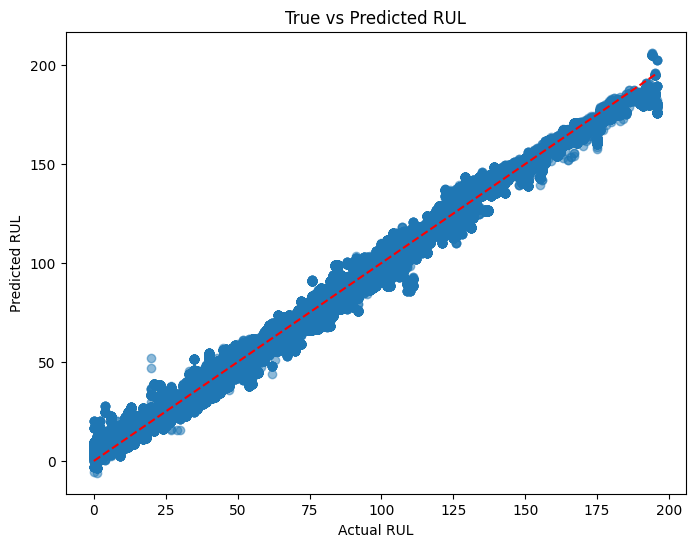

In [19]:
# Import necessary libraries
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# Load your dataset (assuming 'data' is already defined)
# Ensure that 'data' contains all required columns before running this code
input_data = data[['Battery_id', 'Cycle Number', 'Voltage', 'Ambient temp', 'Current',
                   'Temperature', 'Current Load', 'Voltage Load', 'Time',
                   'Fluctuation Index', 'Skewness Index', 'Kurtosis Index', 'Capacity',
                   'SoC', 'Discharge Rate', 'Energy', 'Battery Voltage Slope',
                   'Voltage Range', 'Battery Impedance', 'Power', 'Temperature Deviation']]
X = input_data
y = data['RUL']  # Target variable: Remaining Useful Life (RUL)

# Normalize features using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define XGBoost Regressor model (without hyperparameter tuning)
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=100,
                                 learning_rate=0.1,
                                 max_depth=4,
                                 random_state=42)

# Train the model
xgboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgboost_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)
print("R-squared Score (R2):", r2)

# Plot True vs. Predicted RUL
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='dashed')  # Diagonal line
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("True vs Predicted RUL")
plt.show()


In [12]:
data.shape

(770070, 22)

Cross-Validation RMSE Scores: [1.41100305 1.47248188 1.47321202 1.48911893 1.46392435]
Mean Cross-Validation RMSE: 1.4619480446369109
Test MSE: 1.7520548105239868
Test RMSE: 1.3236520730630035
R²: 0.9992679953575134
Adjusted R²: 0.9992678955335129


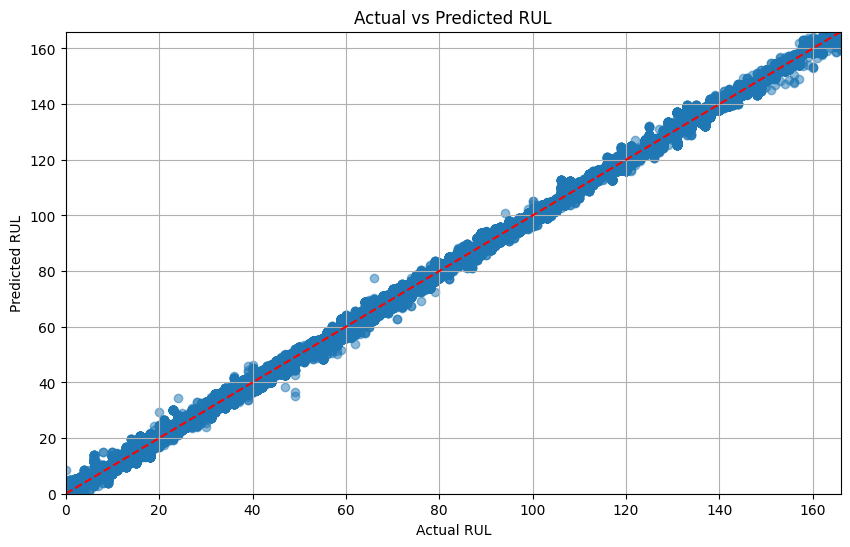

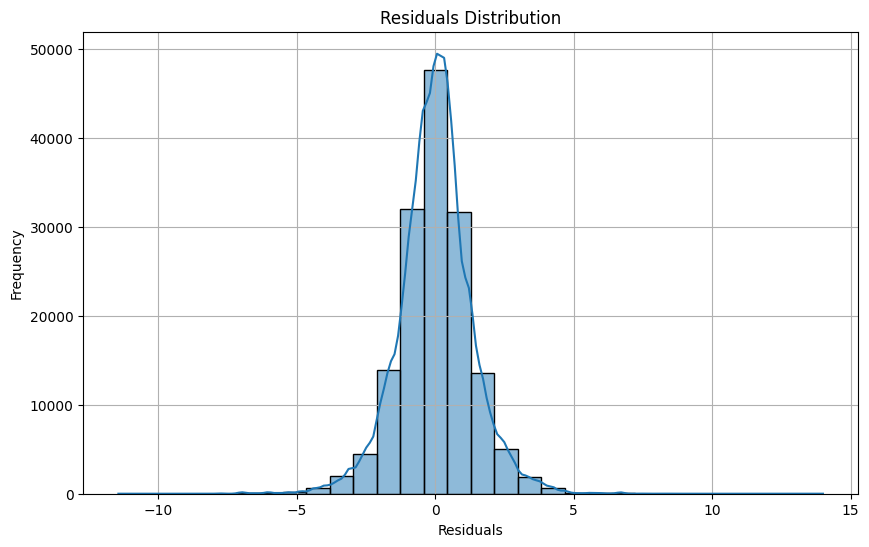

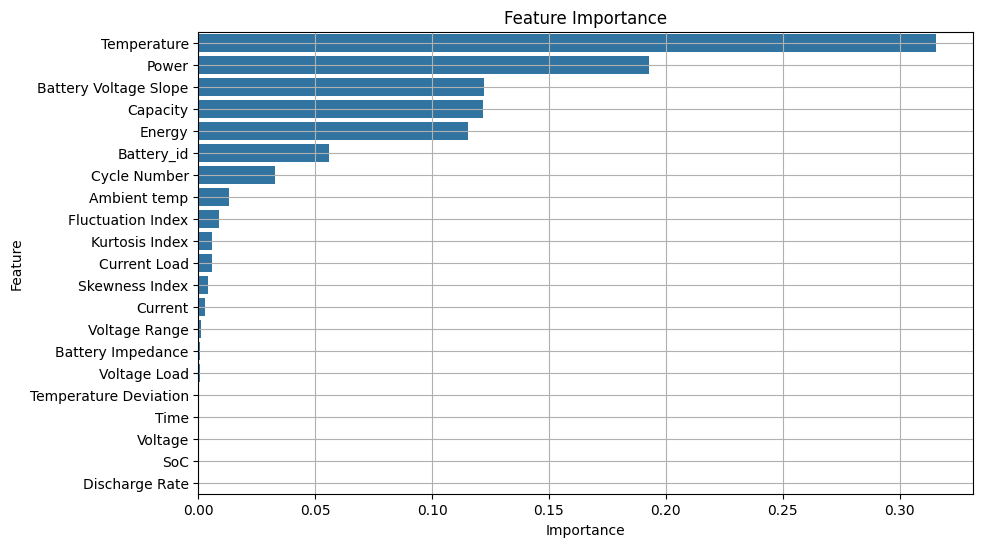

                  Feature  Importance
5             Temperature    0.315825
19                  Power    0.192813
16  Battery Voltage Slope    0.122049
12               Capacity    0.121945
15                 Energy    0.115549
0              Battery_id    0.056090
1            Cycle Number    0.032906
3            Ambient temp    0.012996
9       Fluctuation Index    0.008642
11         Kurtosis Index    0.005850
6            Current Load    0.005844
10         Skewness Index    0.004098
4                 Current    0.002975
17          Voltage Range    0.001105
18      Battery Impedance    0.000665
7            Voltage Load    0.000558
20  Temperature Deviation    0.000044
8                    Time    0.000035
2                 Voltage    0.000013
13                    SoC    0.000000
14         Discharge Rate    0.000000


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

input_data = data[['Battery_id', 'Cycle Number', 'Voltage', 'Ambient temp', 'Current',
       'Temperature', 'Current Load', 'Voltage Load', 'Time',
       'Fluctuation Index', 'Skewness Index', 'Kurtosis Index', 'Capacity',
       'SoC', 'Discharge Rate', 'Energy', 'Battery Voltage Slope',
       'Voltage Range', 'Battery Impedance', 'Power', 'Temperature Deviation']]
X = input_data
y = data['RUL']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=1.0,
    learning_rate=0.2,
    max_depth=5,
    min_child_weight=2,
    subsample=0.6,
    n_estimators=100
)

cv_scores = cross_val_score(xgboost_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

cv_rmse = (-cv_scores) ** 0.5

print("Cross-Validation RMSE Scores:", cv_rmse)
print("Mean Cross-Validation RMSE:", cv_rmse.mean())

xgboost_model.fit(X_train, y_train)

y_pred = xgboost_model.predict(X_test)

test_mse = mean_squared_error(y_test, y_pred)
test_rmse = test_mse ** 0.5

print("Test MSE:", test_mse)
print("Test RMSE:", test_rmse)

r2 = r2_score(y_test, y_pred)
print("R²:", r2)

n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print("Adjusted R²:", adjusted_r2)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([0, 166], [0, 166], color='red', linestyle='--')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.xlim(0, 166)
plt.ylim(0, 166)
plt.grid()
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid()
plt.show()

feature_importance = xgboost_model.feature_importances_
feature_names = input_data.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.grid()
plt.show()

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

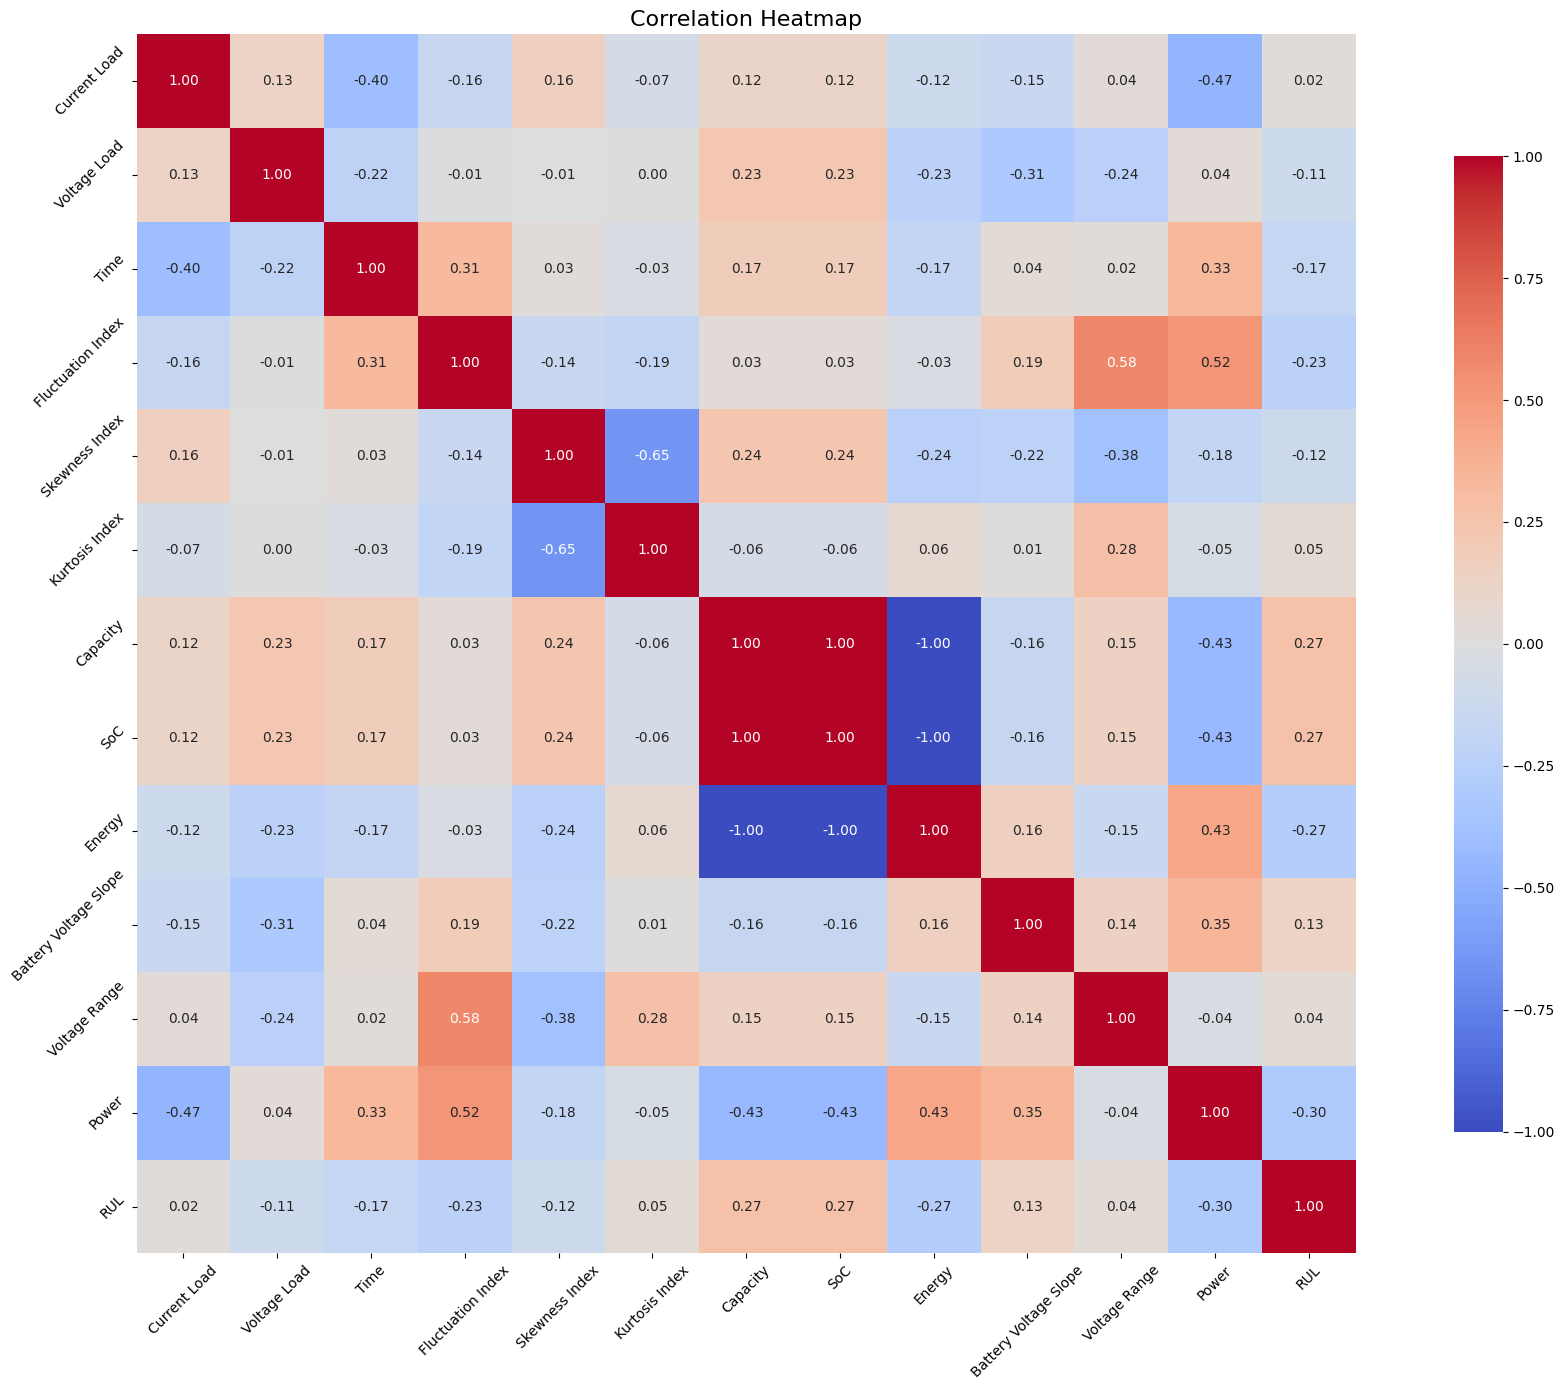

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
# Replace with your actual data loading process
# data = pd.read_csv('your_battery_data.csv')

# Prepare your input features
input_data = data[['Current Load', 'Voltage Load', 'Time',
       'Fluctuation Index', 'Skewness Index', 'Kurtosis Index', 'Capacity',
       'SoC', 'Energy', 'Battery Voltage Slope',
       'Voltage Range',  'Power', 'RUL']]

# Calculate the correlation matrix
correlation_matrix = input_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 14))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Add title and labels
plt.title('Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

Test MSE: 0.010272979729115533
Test RMSE: 0.10135570891230318


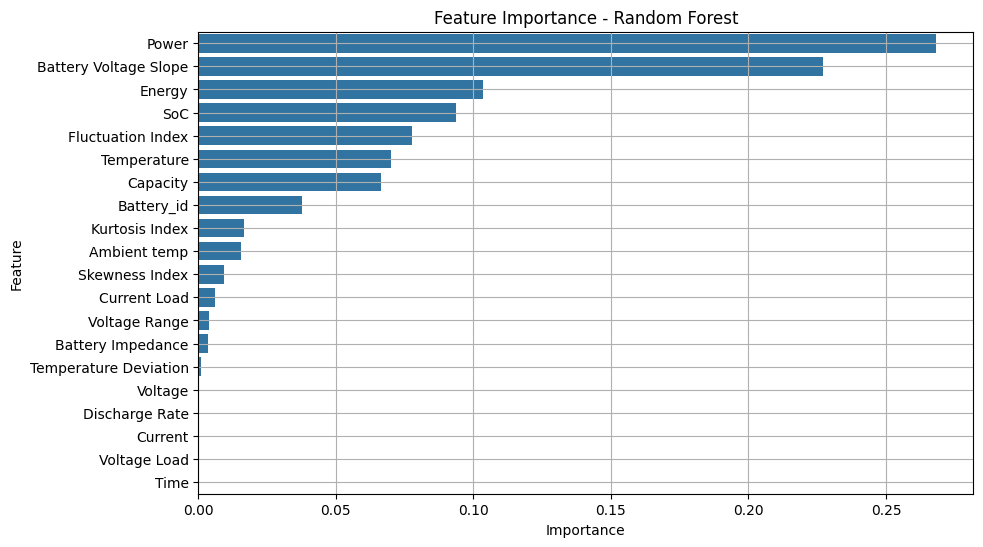

                  Feature    Importance
18                  Power  2.683772e-01
15  Battery Voltage Slope  2.270152e-01
14                 Energy  1.035120e-01
12                    SoC  9.358458e-02
8       Fluctuation Index  7.781984e-02
4             Temperature  7.018892e-02
11               Capacity  6.623928e-02
0              Battery_id  3.766253e-02
10         Kurtosis Index  1.671549e-02
2            Ambient temp  1.532837e-02
9          Skewness Index  9.293190e-03
5            Current Load  5.861751e-03
16          Voltage Range  3.850929e-03
17      Battery Impedance  3.412135e-03
19  Temperature Deviation  9.577900e-04
1                 Voltage  6.128490e-05
13         Discharge Rate  5.110196e-05
3                 Current  3.725102e-05
6            Voltage Load  3.106700e-05
7                    Time  1.464882e-07


In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
# Replace with your actual data loading process
# data = pd.read_csv('your_battery_data.csv')

# Prepare your input features and target variable
X = data[['Battery_id', 'Voltage', 'Ambient temp', 'Current',
       'Temperature', 'Current Load', 'Voltage Load', 'Time',
       'Fluctuation Index', 'Skewness Index', 'Kurtosis Index', 'Capacity',
       'SoC', 'Discharge Rate', 'Energy', 'Battery Voltage Slope',
       'Voltage Range', 'Battery Impedance', 'Power', 'Temperature Deviation']]
y = data['RUL']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=100,  # Number of trees
    max_depth=None,     # None means nodes are expanded until all leaves are pure
    min_samples_split=2,  # Minimum number of samples required to split an internal node
    min_samples_leaf=1,    # Minimum number of samples required to be at a leaf node
    random_state=42
)

# Fit the model on the training set
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Calculate Mean Squared Error on the test set
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = test_mse ** 0.5

print("Test MSE:", test_mse)
print("Test RMSE:", test_rmse)

# Feature Importance
feature_importance = rf_model.feature_importances_
feature_names = X.columns  # Column names

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance - Random Forest')
plt.grid()
plt.show()

print(importance_df)


In [ ]:
# Step 1: Data Preprocessing
# Load the dataset (ensure you load your dataset correctly)
# Example: data = pd.read_csv('your_data.csv')
# For illustration, I'm assuming a placeholder `data` DataFrame.



# Select relevant features for the model
features = ['Current', 'Temperature', 'Capacity', 'SoC', 'Voltage', 'Ambient temp']
X = data[features].values
y = data['RUL'].values  # Target variable

# Normalize the features for better convergence
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature statistics after scaling (for debugging)
print("Feature statistics after scaling:", np.mean(X_scaled, axis=0), np.std(X_scaled, axis=0))

# Step 2: Build the Physics-Informed Neural Network Model

# Define a simple MLP model for PINN
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.dense2 = tf.keras.layers.Dense(64, activation='relu')
        self.dense3 = tf.keras.layers.Dense(1)  # Output layer for RUL

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.dense3(x)

# Instantiate the model
model = PINN()

# Step 3: Physics-Informed Loss Function
def physics_informed_loss(y_true, y_pred, X):
    """
    Physics-informed loss function incorporating battery aging model.
    Simplified aging model with scaling for numerical stability.
    """
    # Unpack inputs
    current = X[:, 0]  # Current
    temperature = X[:, 1]  # Temperature
    cycle = X[:, 2]  # Cycle Number

    # Constants for simplified aging model
    k = 1e-5  # Rate constant (A^-1)
    E_a = 0.3  # Activation energy (eV)
    alpha = 1.0  # Exponent

    # Apply a small epsilon to temperature to avoid division by zero
    epsilon = 1e-6
    temperature = temperature + epsilon  # Ensures temperature is never zero

    # Simplified capacity fade model (like Peukert’s law)
    aging_term = k * current**alpha * tf.exp(-E_a / (8.314 * temperature)) * cycle

    # Scale the aging term for better stability
    aging_term = tf.clip_by_value(aging_term, 1e-3, 1e3)  # Clip values to avoid overflow

    # Ensure both aging_term and y_pred are of type float32
    aging_term = tf.cast(aging_term, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32

    # Physics-informed loss
    physical_loss = tf.reduce_mean(tf.square(aging_term - y_pred))

    # MSE loss (standard loss for regression)
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    # Total loss is a combination of physical and standard loss
    total_loss = mse_loss + physical_loss
    return total_loss

# Step 4: Compile the model with custom loss
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=lambda y_true, y_pred: physics_informed_loss(y_true, y_pred, X_scaled))

# Step 5: Train the model
history = model.fit(X_scaled, y, epochs=5, batch_size=16)

# Step 6: Visualize the results (optional)
# Plot training loss
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Step 7: Evaluate the model (optional)
y_pred = model.predict(X_scaled)

# Plot RUL predictions vs actual
plt.scatter(y, y_pred)
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('True vs Predicted RUL')
plt.show()

Epoch 1/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 798.4907 - mae: 18.3700
Epoch 2/15


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


12033/12033 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 223.8887 - mae: 9.2443
Epoch 3/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 130.3740 - mae: 7.7522
Epoch 4/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 95.7709 - mae: 7.0502
Epoch 5/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 86.0843 - mae: 6.6583
Epoch 6/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 77.7351 - mae: 6.3357
Epoch 7/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 73.1424 - mae: 6.1126
Epoch 8/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 68.3603 - mae: 5.8906
Epoch 9/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 65.2272 - mae: 5.7208
Epoch 10/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 61.2601 - mae: 5.5300
Epoch 11/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 56.4017 - mae: 5.2907
Epoch 12/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 50.9299 - mae: 5.0214
Epoch 13/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 40s 

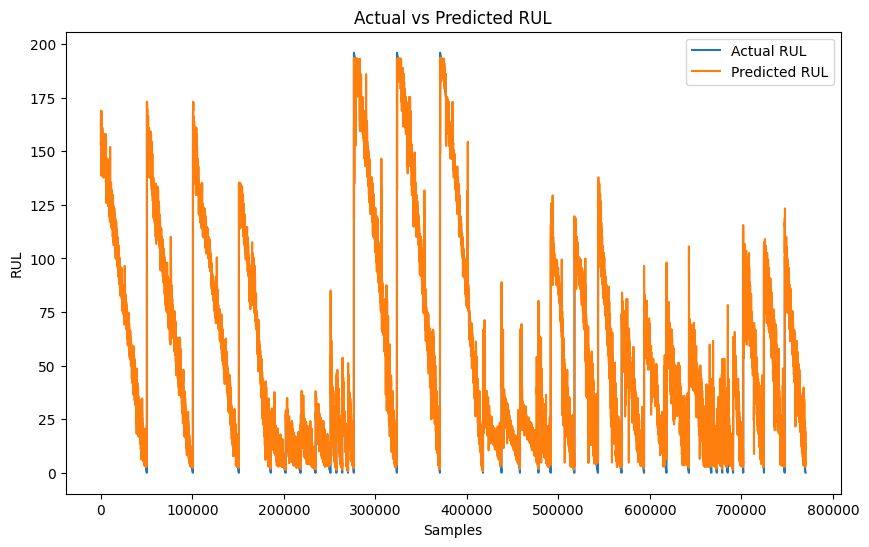

In [15]:
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])
        y.append(target[i + time_steps - 1])
    return np.array(X), np.array(y)

features = ['Voltage', 'Ambient temp', 'Current', 'Temperature',
            'Current Load', 'Voltage Load', 'Fluctuation Index',
            'Skewness Index', 'Kurtosis Index', 'Capacity', 'SoC',
            'Discharge Rate', 'Energy', 'Battery Voltage Slope',
            'Voltage Range', 'Battery Impedance', 'Power', 'Temperature Deviation', 'Time']
X = data[features].values
y = data['RUL'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# number of time steps
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y, time_steps)
y_seq = y_seq.reshape(-1, 1)

# CNN
cnn_model = models.Sequential([
    Input(shape=(time_steps, X_seq.shape[2])),
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
])

cnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cnn_model.fit(X_seq, y_seq, epochs=15, batch_size=64, callbacks= [early_stopping], verbose=1)

# Extract CNN features for XGBoost
X_cnn_features = cnn_model.predict(X_seq)

# Train XGBoost model on CNN features
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', n_estimators=100)
xgb_model.fit(X_cnn_features, y_seq)

# XGBoost
y_pred = xgb_model.predict(X_cnn_features)

# Evaluating
mae = mean_absolute_error(y_seq, y_pred)
mse = mean_squared_error(y_seq, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_seq, y_pred)
print(f'Mean Absolute Error (MAE) for RUL prediction: {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² (Coefficient of Determination): {r2}')

# actual vs predicted RUL plot
plt.figure(figsize=(10, 6))
plt.plot(y_seq, label='Actual RUL')
plt.plot(y_pred, label='Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.xlabel('Samples')
plt.ylabel('RUL')
plt.legend()
plt.show()

Epoch 1/15
8423/8423 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - loss: 946.9477 - mae: 20.3467 - val_loss: 255.0869 - val_mae: 10.0633
Epoch 2/15
8423/8423 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 235.7152 - mae: 9.4911 - val_loss: 212.1371 - val_mae: 8.7326
Epoch 3/15
8423/8423 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - loss: 208.9787 - mae: 8.5812 - val_loss: 205.6238 - val_mae: 8.5807
Epoch 4/15
8423/8423 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 194.3419 - mae: 8.0860 - val_loss: 184.1491 - val_mae: 7.5290
Epoch 5/15
8423/8423 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 185.6904 - mae: 7.7325 - val_loss: 177.3304 - val_mae: 7.4528
Epoch 6/15
8423/8423 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - loss: 176.5989 - mae: 7.4558 - val_loss: 169.5566 - val_mae: 7.1246
Epoch 7/15
8423/8423 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 169.2441 - mae: 7.1529 - val_loss: 165.2981 - val_mae: 7.0005
Epoch 8/15
8423/8423 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 162.9023 - mae: 6.8916 - val_loss: 160.8221 - val_mae: 6.857

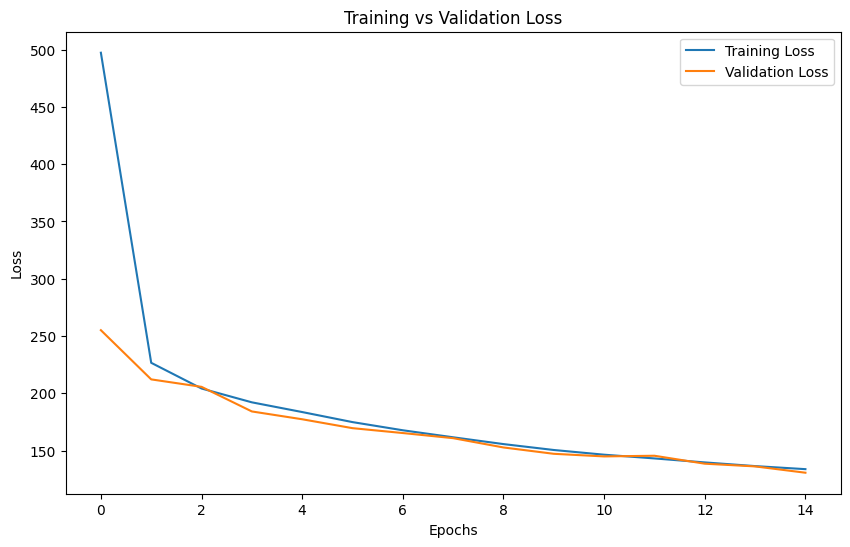

16846/16846 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step
3610/3610 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3610/3610 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation Set Metrics:
Mean Absolute Error (MAE): 3.9925928115844727
Mean Squared Error (MSE): 33.83826446533203
Root Mean Squared Error (RMSE): 5.817066654709402
R² (Coefficient of Determination): 0.9859289526939392
Test Set Metrics:
Mean Absolute Error (MAE): 3.985177993774414
Mean Squared Error (MSE): 33.35291290283203
Root Mean Squared Error (RMSE): 5.775198083428138
R² (Coefficient of Determination): 0.9859399795532227


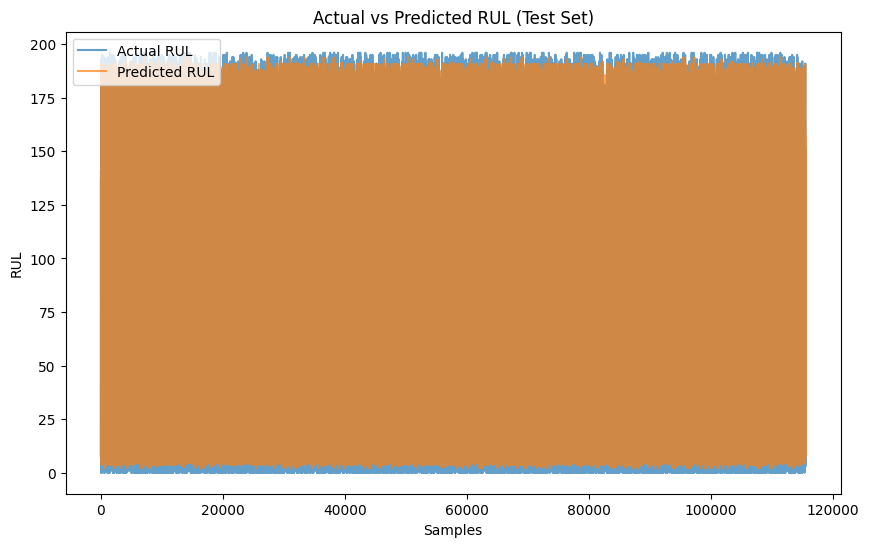

In [14]:
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])
        y.append(target[i + time_steps - 1])
    return np.array(X), np.array(y)

features = ['Voltage', 'Ambient temp', 'Current', 'Temperature',
            'Current Load', 'Voltage Load', 'Fluctuation Index',
            'Skewness Index', 'Kurtosis Index', 'Capacity', 'SoC',
            'Discharge Rate', 'Energy', 'Battery Voltage Slope',
            'Voltage Range', 'Battery Impedance', 'Power', 'Temperature Deviation', 'Time']
X = data[features].values
y = data['RUL'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y, time_steps)
y_seq = y_seq.reshape(-1, 1)

X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#CNN model
cnn_model = models.Sequential([
    Input(shape=(time_steps, X_seq.shape[2])),
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Flatten(),  # Ensure the output is 1D
    layers.Dense(64, activation='relu'),
])

# CNN model with validation data
cnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15, batch_size=64, callbacks= [early_stopping], verbose=1
)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Extract CNN features from the training, validation, and test sets
X_train_cnn = cnn_model.predict(X_train)
X_val_cnn = cnn_model.predict(X_val)
X_test_cnn = cnn_model.predict(X_test)

# Train XGBoost model on CNN-extracted training features
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', n_estimators=100)
xgb_model.fit(X_train_cnn, y_train)

# Evaluate on validation and test sets to check for overfitting
y_val_pred = xgb_model.predict(X_val_cnn)
y_test_pred = xgb_model.predict(X_test_cnn)

# Metrics for validation set
val_mae = mean_absolute_error(y_val, y_val_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val, y_val_pred)

print(f'Validation Set Metrics:')
print(f'Mean Absolute Error (MAE): {val_mae}')
print(f'Mean Squared Error (MSE): {val_mse}')
print(f'Root Mean Squared Error (RMSE): {val_rmse}')
print(f'R² (Coefficient of Determination): {val_r2}')

# Metrics for test set
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Test Set Metrics:')
print(f'Mean Absolute Error (MAE): {test_mae}')
print(f'Mean Squared Error (MSE): {test_mse}')
print(f'Root Mean Squared Error (RMSE): {test_rmse}')
print(f'R² (Coefficient of Determination): {test_r2}')

# Plot actual vs predicted RUL for test set
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual RUL', alpha=0.7)
plt.plot(y_test_pred, label='Predicted RUL', alpha=0.7)
plt.title('Actual vs Predicted RUL (Test Set)')
plt.xlabel('Samples')
plt.ylabel('RUL')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
19252/19252 ━━━━━━━━━━━━━━━━━━━━ 194s 10ms/step - loss: 405.0542 - mae: 13.3154 - val_loss: 1964.6293 - val_mae: 34.4375 - learning_rate: 0.0010
Epoch 2/15
19252/19252 ━━━━━━━━━━━━━━━━━━━━ 199s 10ms/step - loss: 124.6871 - mae: 7.7999 - val_loss: 1991.8965 - val_mae: 32.4794 - learning_rate: 0.0010
Epoch 3/15
19252/19252 ━━━━━━━━━━━━━━━━━━━━ 203s 10ms/step - loss: 98.5308 - mae: 6.9958 - val_loss: 2217.1875 - val_mae: 33.6123 - learning_rate: 0.0010
Epoch 4/15
19252/19252 ━━━━━━━━━━━━━━━━━━━━ 190s 10ms/step - loss: 87.9273 - mae: 6.6065 - val_loss: 2280.1165 - val_mae: 34.0757 - learning_rate: 0.0010
Epoch 5/15
19252/19252 ━━━━━━━━━━━━━━━━━━━━ 203s 10ms/step - loss: 71.3661 - mae: 5.9491 - val_loss: 2140.8059 - val_mae: 33.9302 - learning_rate: 5.0000e-04
Epoch 6/15
19252/19252 ━━━━━━━━━━━━━━━━━━━━ 201s 10ms/step - loss: 65.2883 - mae: 5.6811 - val_loss: 2227.0737 - val_mae: 33.6871 - learning_rate: 5.0000e-04
Epoch 7/15
19252/19252 ━━━━━━━━━━━━━━━━━━━━ 188s 10ms/step - loss

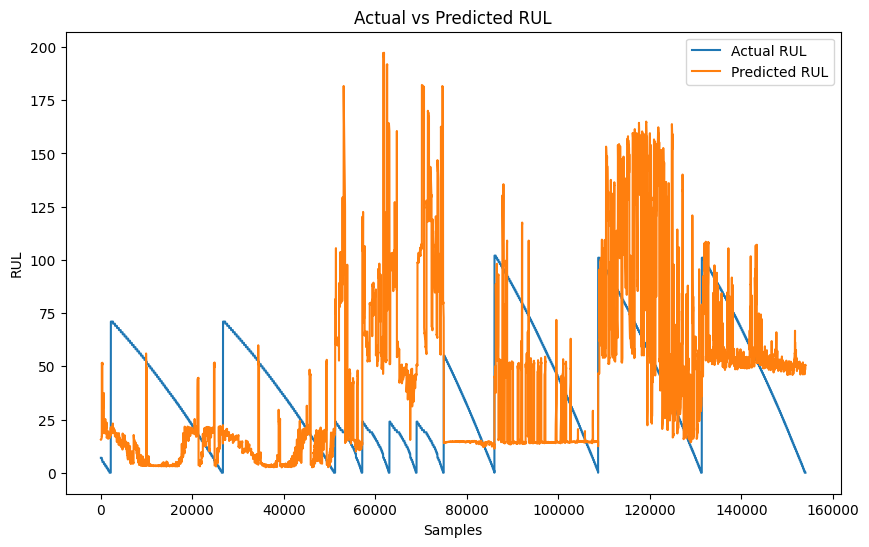

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

# Function to create sequences for time-series data
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])
        y.append(target[i + time_steps - 1])
    return np.array(X), np.array(y)

# Extract features and target
features = ['Voltage', 'Ambient temp', 'Current', 'Temperature',
            'Current Load', 'Voltage Load', 'Fluctuation Index',
            'Skewness Index', 'Kurtosis Index', 'Capacity', 'SoC',
            'Discharge Rate', 'Energy', 'Battery Voltage Slope',
            'Voltage Range', 'Battery Impedance', 'Power', 'Temperature Deviation', 'Time']
X = data[features].values
y = data['RUL'].values  # Remaining Useful Life (RUL) is the target variable

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define time steps and create sequences
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y, time_steps)
y_seq = y_seq.reshape(-1, 1)

# Split into training and validation sets
train_size = int(0.8 * len(X_seq))
X_train, X_val = X_seq[:train_size], X_seq[train_size:]
y_train, y_val = y_seq[:train_size], y_seq[train_size:]

# Build the model with improved architecture
model = models.Sequential()

# CNN Layer 1
model.add(layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Dropout(0.4))

# CNN Layer 2
model.add(layers.Conv1D(128, kernel_size=3, activation='relu'))
model.add(layers.Dropout(0.4))

# CNN Layer 3
model.add(layers.Conv1D(256, kernel_size=3, activation='relu'))
model.add(layers.Dropout(0.4))

# Bidirectional LSTM Layer
model.add(layers.Bidirectional(layers.LSTM(100, return_sequences=False)))
model.add(layers.Dropout(0.5))

# Dense Layer
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.4))

# Output Layer
model.add(layers.Dense(1))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Callbacks for learning rate adjustment and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

# Evaluate the model
loss, mae = model.evaluate(X_val, y_val, verbose=0)
print(f"Final Model - MAE: {mae}")

# Predict with the model
y_pred = model.predict(X_val)

# Evaluate the model performance
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")

# Plot actual vs predicted RUL
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='Actual RUL')
plt.plot(y_pred, label='Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.xlabel('Samples')
plt.ylabel('RUL')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
19252/19252 ━━━━━━━━━━━━━━━━━━━━ 186s 9ms/step - loss: 441.5279 - mae: 13.3834 - val_loss: 1619.0129 - val_mae: 28.9946 - learning_rate: 0.0010
Epoch 2/15
19252/19252 ━━━━━━━━━━━━━━━━━━━━ 182s 9ms/step - loss: 115.3413 - mae: 7.5122 - val_loss: 1535.1106 - val_mae: 30.7077 - learning_rate: 0.0010
Epoch 3/15
19252/19252 ━━━━━━━━━━━━━━━━━━━━ 198s 9ms/step - loss: 92.9169 - mae: 6.6930 - val_loss: 2307.3179 - val_mae: 34.9766 - learning_rate: 0.0010
Epoch 4/15
19252/19252 ━━━━━━━━━━━━━━━━━━━━ 202s 9ms/step - loss: 82.8956 - mae: 6.3087 - val_loss: 1857.1332 - val_mae: 32.8396 - learning_rate: 0.0010
Epoch 5/15
19252/19252 ━━━━━━━━━━━━━━━━━━━━ 182s 9ms/step - loss: 67.6357 - mae: 5.6956 - val_loss: 1650.9257 - val_mae: 32.0861 - learning_rate: 5.0000e-04
Epoch 6/15
19252/19252 ━━━━━━━━━━━━━━━━━━━━ 202s 9ms/step - loss: 64.5586 - mae: 5.5430 - val_loss: 1783.8313 - val_mae: 31.9287 - learning_rate: 5.0000e-04
Epoch 7/15
19252/19252 ━━━━━━━━━━━━━━━━━━━━ 197s 9ms/step - loss: 59.83

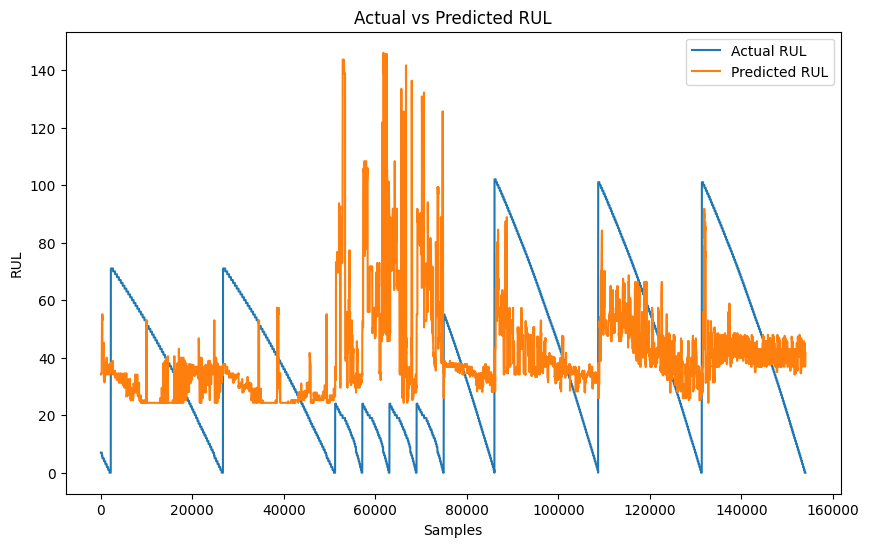

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

# Function to create sequences for time-series data
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])
        y.append(target[i + time_steps - 1])  # Use the RUL of the last time step in the sequence
    return np.array(X), np.array(y)

# Extract features and target
features = ['Voltage', 'Ambient temp', 'Current', 'Temperature',
            'Current Load', 'Voltage Load', 'Fluctuation Index',
            'Skewness Index', 'Kurtosis Index', 'Capacity', 'SoC',
            'Discharge Rate', 'Energy', 'Battery Voltage Slope',
            'Voltage Range', 'Battery Impedance', 'Power', 'Temperature Deviation', 'Time']
X = data[features].values
y = data['RUL'].values  # Remaining Useful Life (RUL) is the target variable

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define time steps and create sequences
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y, time_steps)
y_seq = y_seq.reshape(-1, 1)

# Split into training and validation sets
train_size = int(0.8 * len(X_seq))
X_train, X_val = X_seq[:train_size], X_seq[train_size:]
y_train, y_val = y_seq[:train_size], y_seq[train_size:]

# Build CNN-LSTM model with 2 CNN layers and reduced LSTM units
cnn_lstm_model = Sequential()

# CNN Layer 1
cnn_lstm_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
cnn_lstm_model.add(Dropout(0.3))  # Reduced dropout rate

# CNN Layer 2
cnn_lstm_model.add(Conv1D(128, kernel_size=3, activation='relu'))
cnn_lstm_model.add(Dropout(0.3))  # Reduced dropout rate

# Bidirectional LSTM Layer with fewer units
cnn_lstm_model.add(Bidirectional(LSTM(50, return_sequences=False)))  # Reduced units
cnn_lstm_model.add(Dropout(0.4))

# Dense Layer
cnn_lstm_model.add(Dense(64, activation='relu'))  # Reduced units
cnn_lstm_model.add(Dropout(0.3))  # Reduced dropout rate

# Output Layer
cnn_lstm_model.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate=0.001)
cnn_lstm_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Callbacks for learning rate adjustment and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)  # Reduced patience
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Reduced patience

# Train the CNN-LSTM model
cnn_lstm_model.fit(
    X_train, y_train,
    epochs=15,  # Reduced epochs
    batch_size=32,  # Kept batch size
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

# Extract CNN features
cnn_features_train = cnn_lstm_model.predict(X_train)
cnn_features_val = cnn_lstm_model.predict(X_val)

# Reshape the CNN features to be used by XGBoost
cnn_features_train_reshaped = cnn_features_train.reshape(cnn_features_train.shape[0], -1)
cnn_features_val_reshaped = cnn_features_val.reshape(cnn_features_val.shape[0], -1)

# Train the XGBoost model
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=5, alpha=10, n_estimators=10)

xg_reg.fit(cnn_features_train_reshaped, y_train)

# Predict with XGBoost model
y_pred_xgboost = xg_reg.predict(cnn_features_val_reshaped)

# Evaluate the model performance
mse = mean_squared_error(y_val, y_pred_xgboost)
mae = mean_absolute_error(y_val, y_pred_xgboost)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred_xgboost)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")

# Plot actual vs predicted RUL
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='Actual RUL')
plt.plot(y_pred_xgboost, label='Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.xlabel('Samples')
plt.ylabel('RUL')
plt.legend()
plt.show()

Epoch 1/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 69s 6ms/step - loss: 1877.4122 - mae: 27.0695
Epoch 2/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - loss: 53.0209 - mae: 4.2807
Epoch 3/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - loss: 28.7738 - mae: 3.0574
Epoch 4/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - loss: 21.7248 - mae: 2.5734
Epoch 5/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - loss: 17.4380 - mae: 2.2875
Epoch 6/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 66s 6ms/step - loss: 15.2715 - mae: 2.1023
Epoch 7/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 68s 6ms/step - loss: 13.8520 - mae: 1.9760
Epoch 8/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 83s 6ms/step - loss: 11.9790 - mae: 1.8357
Epoch 9/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - loss: 11.7789 - mae: 1.8276
Epoch 10/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - loss: 10.2432 - mae: 1.7240
Epoch 11/15
12033/12033 ━━━━━━━━━━━━━━━━━━━━ 67s 6ms/step - loss: 9.6772 - mae: 1.6653
Epoch 12/15
12033/12033 ━━━━━━━━━━━━━━━

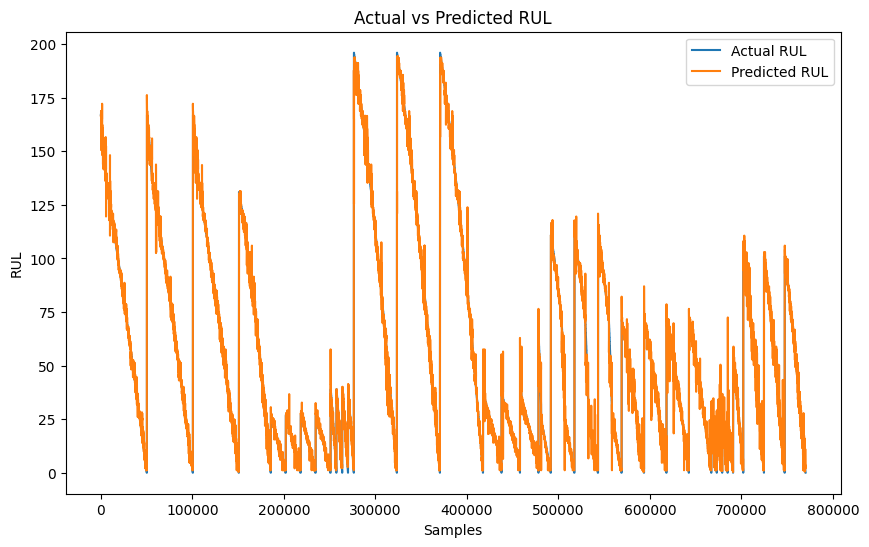

In [16]:
from keras.models import Sequential
from keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])
        y.append(target[i + time_steps - 1])
    return np.array(X), np.array(y)

# Prepare your features and target
features = ['Voltage', 'Ambient temp', 'Current', 'Temperature',
            'Current Load', 'Voltage Load', 'Fluctuation Index',
            'Skewness Index', 'Kurtosis Index', 'Capacity', 'SoC',
            'Discharge Rate', 'Energy', 'Battery Voltage Slope',
            'Voltage Range', 'Battery Impedance', 'Power', 'Temperature Deviation', 'Time']
X = data[features].values
y = data['RUL'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define sequence length
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y, time_steps)
y_seq = y_seq.reshape(-1, 1)

# CNN-LSTM Model
cnn_lstm_model = Sequential([
    layers.Input(shape=(time_steps, X_seq.shape[2])),

    # CNN layers
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),

    # LSTM layer
    layers.LSTM(64, return_sequences=False),  # LSTM for temporal dependencies

    # Dense layer to flatten output for XGBoost
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
])

cnn_lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Fit the model
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
cnn_lstm_model.fit(X_seq, y_seq, epochs=15, batch_size=64, callbacks=[early_stopping], verbose=1)

# Extract CNN-LSTM features for XGBoost
X_cnn_lstm_features = cnn_lstm_model.predict(X_seq)

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', n_estimators=100)
xgb_model.fit(X_cnn_lstm_features, y_seq)

# Predict RUL
y_pred = xgb_model.predict(X_cnn_lstm_features)

# Evaluate model
mae = mean_absolute_error(y_seq, y_pred)
mse = mean_squared_error(y_seq, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_seq, y_pred)

print(f'Mean Absolute Error (MAE) for RUL prediction: {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² (Coefficient of Determination): {r2}')

# Plot Actual vs Predicted RUL
plt.figure(figsize=(10, 6))
plt.plot(y_seq, label='Actual RUL')
plt.plot(y_pred, label='Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.xlabel('Samples')
plt.ylabel('RUL')
plt.legend()
plt.show()

Epoch 1/15
8423/8423 ━━━━━━━━━━━━━━━━━━━━ 57s 6ms/step - loss: 2319.9226 - mae: 31.1947 - val_loss: 89.0419 - val_mae: 6.3723
Epoch 2/15
8423/8423 ━━━━━━━━━━━━━━━━━━━━ 85s 7ms/step - loss: 70.7613 - mae: 5.6541 - val_loss: 33.0369 - val_mae: 3.7142
Epoch 3/15
8423/8423 ━━━━━━━━━━━━━━━━━━━━ 77s 6ms/step - loss: 33.3025 - mae: 3.7171 - val_loss: 29.1378 - val_mae: 3.2568
Epoch 4/15
8423/8423 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step - loss: 24.1108 - mae: 3.0783 - val_loss: 17.7619 - val_mae: 2.6580
Epoch 5/15
8423/8423 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - loss: 20.2765 - mae: 2.7828 - val_loss: 16.5365 - val_mae: 2.5903
Epoch 6/15
8423/8423 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - loss: 17.2901 - mae: 2.5432 - val_loss: 15.1315 - val_mae: 2.4207
Epoch 7/15
8423/8423 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - loss: 15.7816 - mae: 2.3952 - val_loss: 11.1026 - val_mae: 2.0879
Epoch 8/15
8423/8423 ━━━━━━━━━━━━━━━━━━━━ 78s 6ms/step - loss: 14.5702 - mae: 2.3120 - val_loss: 9.9436 - val_mae: 1.9533
Epoch 9/15
842

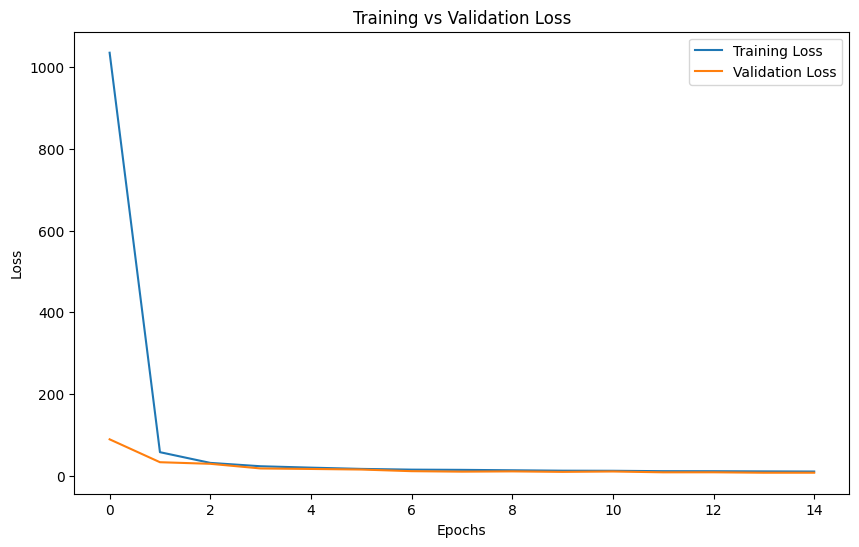

16846/16846 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step
3610/3610 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
3610/3610 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
Validation Set Metrics:
Mean Absolute Error (MAE): 1.5497206449508667
Mean Squared Error (MSE): 6.657596111297607
Root Mean Squared Error (RMSE): 2.5802317941025392
R² (Coefficient of Determination): 0.9972315430641174
Test Set Metrics:
Mean Absolute Error (MAE): 1.5534954071044922
Mean Squared Error (MSE): 6.482512950897217
Root Mean Squared Error (RMSE): 2.54607795459943
R² (Coefficient of Determination): 0.9972672462463379


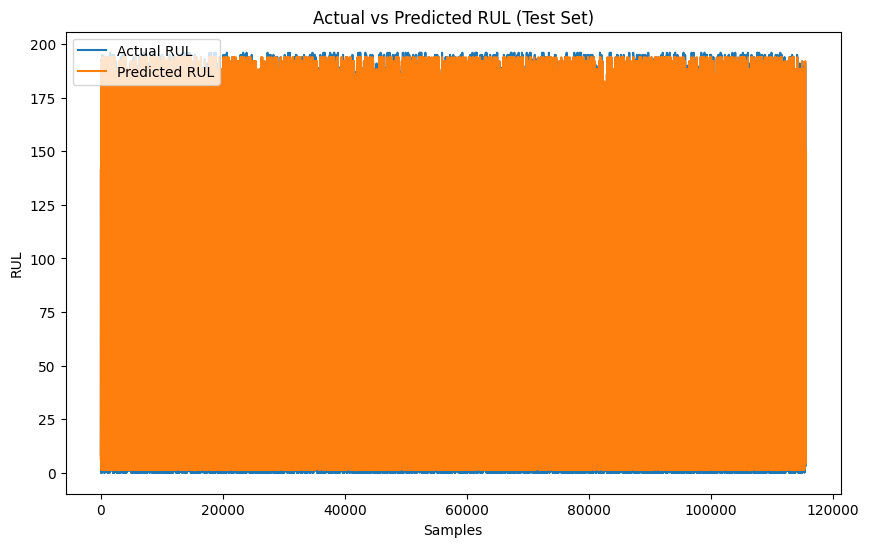

In [13]:
from keras.models import Sequential
from keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

# Prepare your features and target
features = ['Voltage', 'Ambient temp', 'Current', 'Temperature',
            'Current Load', 'Voltage Load', 'Fluctuation Index',
            'Skewness Index', 'Kurtosis Index', 'Capacity', 'SoC',
            'Discharge Rate', 'Energy', 'Battery Voltage Slope',
            'Voltage Range', 'Battery Impedance', 'Power', 'Temperature Deviation', 'Time']
X = data[features].values
y = data['RUL'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create sequences
time_steps = 10
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])
        y.append(target[i + time_steps - 1])
    return np.array(X), np.array(y)

X_seq, y_seq = create_sequences(X_scaled, y, time_steps)
y_seq = y_seq.reshape(-1, 1)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# CNN-LSTM Model
cnn_lstm_model = Sequential([
    layers.Input(shape=(time_steps, X_seq.shape[2])),

    # CNN layers
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),

    # LSTM layer
    layers.LSTM(64, return_sequences=False),  # LSTM for temporal dependencies

    # Dense layer to flatten output for XGBoost
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
])

cnn_lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Fit the model with validation data
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = cnn_lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=64, callbacks=[early_stopping], verbose=1)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Extract CNN-LSTM features for XGBoost
X_train_cnn_lstm = cnn_lstm_model.predict(X_train)
X_val_cnn_lstm = cnn_lstm_model.predict(X_val)
X_test_cnn_lstm = cnn_lstm_model.predict(X_test)

# Train XGBoost model on CNN-LSTM features
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', n_estimators=100)
xgb_model.fit(X_train_cnn_lstm, y_train)

# Evaluate on validation set
y_val_pred = xgb_model.predict(X_val_cnn_lstm)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val, y_val_pred)

print(f'Validation Set Metrics:')
print(f'Mean Absolute Error (MAE): {val_mae}')
print(f'Mean Squared Error (MSE): {val_mse}')
print(f'Root Mean Squared Error (RMSE): {val_rmse}')
print(f'R² (Coefficient of Determination): {val_r2}')

# Evaluate on test set
y_test_pred = xgb_model.predict(X_test_cnn_lstm)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Test Set Metrics:')
print(f'Mean Absolute Error (MAE): {test_mae}')
print(f'Mean Squared Error (MSE): {test_mse}')
print(f'Root Mean Squared Error (RMSE): {test_rmse}')
print(f'R² (Coefficient of Determination): {test_r2}')

# Plot actual vs predicted RUL for test set
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual RUL')
plt.plot(y_test_pred, label='Predicted RUL')
plt.title('Actual vs Predicted RUL (Test Set)')
plt.xlabel('Samples')
plt.ylabel('RUL')
plt.legend()
plt.show()

In [14]:
# Function to create sequences for time-series prediction
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])
        y.append(target[i + time_steps - 1])
    return np.array(X), np.array(y)

# Feature extraction using FFT (Fourier Transform)
def extract_fourier_features(signal):
    """Extract features using FFT."""
    fft_result = fft(signal)
    fft_abs = np.abs(fft_result)
    fft_freq = np.fft.fftfreq(len(signal))
    # Keep only the positive frequencies
    positive_freq = fft_freq[:len(fft_freq)//2]
    positive_abs = fft_abs[:len(fft_freq)//2]

    # Extract common frequency-domain features
    mean_freq = np.mean(positive_abs)
    std_freq = np.std(positive_abs)
    max_freq = np.max(positive_abs)
    dominant_freq = positive_freq[np.argmax(positive_abs)]

    return [mean_freq, std_freq, max_freq, dominant_freq]

# Feature extraction using Wavelet Transform (WT)
def extract_wavelet_features(signal):
    """Extract features using Wavelet Transform."""
    coeffs = pywt.wavedec(signal, 'db4', level=min(4, pywt.dwt_max_level(len(signal), pywt.Wavelet('db4'))))
    # Extract features from the wavelet coefficients
    wavelet_features = []
    for coeff in coeffs:
        wavelet_features.append(np.mean(coeff))
        wavelet_features.append(np.std(coeff))
        wavelet_features.append(np.max(coeff))
    return wavelet_features

# Extract features from each column (Voltage, Current, Temperature, etc.) in the dataset
def extract_all_features(data, features, time_steps):
    all_features = []
    for i in range(len(data) - time_steps):  # Loop to form sequences of time_steps length
        feature_vector = []
        for feature in features:
            signal = data[feature].iloc[i:i + time_steps].values  # Extract the time-series for each feature
            # Extract FFT and Wavelet features for the signal
            fft_features = extract_fourier_features(signal)
            wavelet_features = extract_wavelet_features(signal)
            feature_vector.extend(fft_features + wavelet_features)  # Combine both feature sets
        all_features.append(feature_vector)
    return np.array(all_features)

# Assuming `data` is your DataFrame containing the features like Voltage, Current, etc.
# And `features` is a list of feature column names
features = ['Voltage', 'Current', 'Temperature',
            'Current Load', 'Voltage Load','Capacity', 'SoC',
            'Discharge Rate', 'Energy','Battery Impedance', 'Power', 'Time']

# Normalize the features
scaler = StandardScaler()

# Extract features and target variable (RUL)
X_features = extract_all_features(data, features, time_steps=10)  # 10 is the chosen time_steps length
X_scaled = scaler.fit_transform(X_features)  # Normalize the features
time_steps = 10  # Or any value of your choice for sequence length
# Target variable (RUL values)
y = data['RUL'].values[time_steps:]  # Ensure correct target indexing

# Create sequences (X_seq) and targets (y_seq)
X_seq, y_seq = create_sequences(X_scaled, y, time_steps=10)

# CNN-LSTM Model
cnn_lstm_model = Sequential([
    layers.Input(shape=(X_seq.shape[1], X_seq.shape[2])),

    # CNN layers
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),

    # LSTM layer
    layers.LSTM(64, return_sequences=False),

    # Dense layer
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Output layer
])

cnn_lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Fit the model
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
cnn_lstm_model.fit(X_seq, y_seq, epochs=15, batch_size=64, callbacks=[early_stopping], verbose=1)

# Predict RUL with CNN-LSTM
y_cnn_lstm_pred = cnn_lstm_model.predict(X_seq)

# Train XGBoost model (Optional - If you want to add an additional layer of prediction)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', n_estimators=100)
xgb_model.fit(y_cnn_lstm_pred, y_seq)  # Train with CNN-LSTM features

# Predict RUL using XGBoost
y_pred = xgb_model.predict(y_cnn_lstm_pred)

# Evaluate model
mae = mean_absolute_error(y_seq, y_pred)
mse = mean_squared_error(y_seq, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_seq, y_pred)

print(f'Mean Absolute Error (MAE) for RUL prediction: {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² (Coefficient of Determination): {r2}')

# Plot Actual vs Predicted RUL
plt.figure(figsize=(10, 6))
plt.plot(y_seq, label='Actual RUL')
plt.plot(y_pred, label='Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.xlabel('Samples')
plt.ylabel('RUL')
plt.legend()
plt.show()

KeyboardInterrupt: 